In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import glob

In [46]:
files = glob.glob("*/bench*/score.tsv")
parts = []
ptc_parts = []
for fn in files:
    prog, seq, _ = fn.split('/')
    seq = seq.split('_')
    tech = seq[2]
    gcc = seq[4]
    data = pd.read_csv(fn, sep='\t')
    data['prog'] = prog
    data['tech'] = tech
    data['center'] = gcc
    ptc_parts.append([prog, tech, gcc])
    parts.append(data)

data = pd.concat(parts)
m = {'hifi': 'HiFi',
     'ill': 'Illumina',
     'ontstd': 'ONT'}
data['tech'] = data['tech'].map(m)

ptc = pd.DataFrame(ptc_parts, columns=['prog', 'tech', 'center'])
ptc['tech'] = ptc['tech'].map(m)

In [47]:
features = data['feature'].unique()
n_strats = 1
n_strats_none = 1
n_values = 0
for i in features:
    c = data[data['feature'] == i]['value'].nunique()
    n_strats *= c
    n_strats_none *= c+1
    n_values += c
print(n_strats, n_values, n_strats_none)

320 20 1485


In [48]:
problems = data[data['reject']][['feature', 'value']].value_counts()
problems

feature   value          
VAF_bin   SomaticLow(<5%)    39
isolated  False              35
svtype    INS                15
TRF       True               13
szbin     [100,200)           9
VAF_bin   Somatic             7
szbin     [50,100)            5
Name: count, dtype: int64

In [57]:
# Step 1: Filter to just rejected entries
rejected = data[data['reject']]

# Step 2: Group by feature, value, and tech; count occurrences
grouped = rejected.groupby(['feature', 'value', 'tech']).size().unstack(fill_value=0)

# Step 3: Add total count (across techs) as a column
grouped['Total'] = grouped.sum(axis=1)

# Optional: sort by total or feature
grouped_reject = grouped.sort_values('Total', ascending=False)[['Total', 'HiFi', "Illumina", 'ONT']]


not_rejected = data[~data['reject']].set_index(['feature', 'value']).loc[grouped_reject.index].reset_index()

# Step 2: Group by feature, value, and tech; count occurrences
grouped = not_rejected.groupby(['feature', 'value', 'tech']).size().unstack(fill_value=0)

# Step 3: Add total count (across techs) as a column
grouped['Total'] = grouped.sum(axis=1)

# Optional: sort by total or feature
grouped_not = grouped.sort_values('Total', ascending=False)[['Total', 'HiFi', "Illumina", 'ONT']]

grouped_reject.columns = pd.MultiIndex.from_product([['Reject'], grouped_reject.columns])
grouped_not.columns = pd.MultiIndex.from_product([['Pass'], grouped_not.columns])

tech_reject = grouped_reject.join(grouped_not)

renamer = {('VAF_bin', 'SomaticLow(<5%)'): "SomaticLow(<5%)",
           ('isolated', 'False'): "Neighboring",
           ('TRF', 'True'): "TR Regions",
           ('svtype', "INS"): "Insertions",
           ('VAF_bin', 'Somatic'): "Somatic",
           ('szbin', '[50,100)'): "Small [50,100)",
           ('szbin', '[100,200)'): "Small [100,200)"}

tech_reject['Label'] = tech_reject.index.map(renamer)
tech_reject.reset_index(drop=True)[['Label', 'Reject', 'Pass']]

Label Reject                    Pass                  
tech                   Total HiFi Illumina ONT Total HiFi Illumina ONT
0     SomaticLow(<5%)     39   24        9   6     6    0        6   0
1         Neighboring     35   17       13   5    10    7        2   1
2          Insertions     15    0       15   0    30   24        0   6
3          TR Regions     13    0       13   0    32   24        2   6
4     Small [100,200)      9    0        9   0    36   24        6   6
5             Somatic      7    4        0   3    38   20       15   3
6      Small [50,100)      5    0        5   0    40   24       10   6

In [59]:
ptc['prog'].nunique(), ptc['tech'].nunique(), ptc['center'].nunique()

(8, 3, 5)

In [44]:
grouped_reject.join(grouped_not, lsuffix='_reject', rsuffix='_pass')


,tech,hifi_reject,ill_reject,ontstd_reject,total_reject,hifi_pass,ill_pass,ontstd_pass,total_pass
feature,value,,,,,,,,
VAF_bin,SomaticLow(<5%),24,9,6,39,0,6,0,6
isolated,False,17,13,5,35,7,2,1,10
svtype,INS,0,15,0,15,24,0,6,30
TRF,True,0,13,0,13,24,2,6,32
szbin,"[100,200)",0,9,0,9,24,6,6,36
VAF_bin,Somatic,4,0,3,7,20,15,3,38
szbin,"[50,100)",0,5,0,5,24,10,6,40


In [33]:
lookup = 
for i in problems.index:
    val = problems.loc[i]
    

In [31]:
df = up.reset_index(name='count')
df_wide = df.pivot_table(index=['feature', 'value'], columns='tech', values='count', fill_value=0)

presence = df_wide > 0

# Group by technology presence pattern
grouped = df_wide.groupby(presence.values.tolist()).sum()

# Reset index to get a proper MultiIndex for UpSetPlot
grouped.index = pd.MultiIndex.from_tuples(grouped.index, names=df_wide.columns)

# Sum across techs to get a single count per combination (optional: or keep per-tech if needed)
upset_df = grouped.sum(axis=1)


upset_df

KeyError: True

In [9]:
# Upset Plot of technologies that have each of the features
from upsetplot import plot as upsetplot
up = data[data['reject']][['feature', 'value', 'tech']].value_counts()
upsetplot(up)
plt.show()

ValueError: The DataFrame has values in its index that are not boolean

In [61]:
order = sorted(list(data['prog'].unique()))
hue_order = sorted(list(data['tech'].unique()))

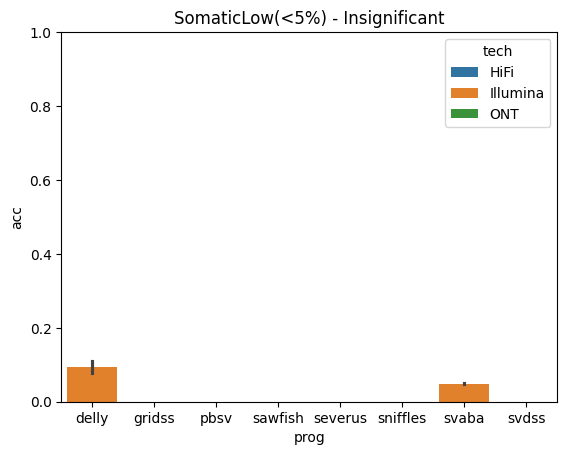

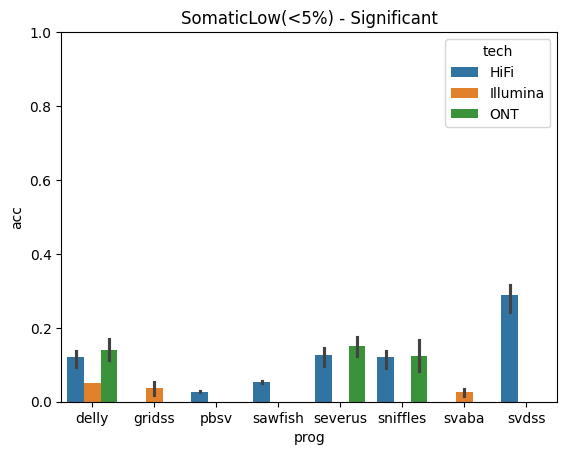

In [62]:
view = data.set_index(['feature', 'value'])
view.sort_index(inplace=True)
for i in problems.index:
    sub = view.loc[i]
    notproblem = sub[~sub['reject']]
    isproblem = sub[sub['reject']]
    p = sb.barplot(data=notproblem, x='prog', y='acc', hue='tech', 
               order=order, hue_order=hue_order,)
    p.set(title="SomaticLow(<5%) - Insignificant",
          ylim=(0,1))
    plt.show()

    p = sb.barplot(data=isproblem, x='prog', y='acc', hue='tech', 
               order=order, hue_order=hue_order)
    p.set(title="SomaticLow(<5%) - Significant",
          ylim=(0,1))
    plt.show()
    break
    print(i, problems.loc[i], '/', len(ptc))
    print('\tG=', notproblem['tech'].value_counts().to_dict(), '\n\tP=', isproblem['tech'].value_counts().to_dict())
    print('\tG=', notproblem['center'].value_counts().to_dict(), '\n\tP=', isproblem['center'].value_counts().to_dict())
    print('\tG=', notproblem['prog'].value_counts().to_dict(), '\n\tP=', isproblem['prog'].value_counts().to_dict())
    print()

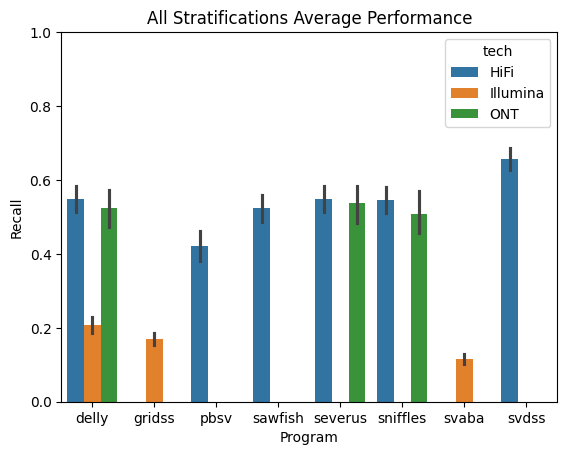

In [63]:
p = sb.barplot(data=data, x='prog', y='acc', hue='tech', order=order, hue_order=hue_order)
_ = p.set(title="All Stratifications Average Performance", 
          xlabel="Program", 
          ylabel="Recall",
         ylim=(0,1))

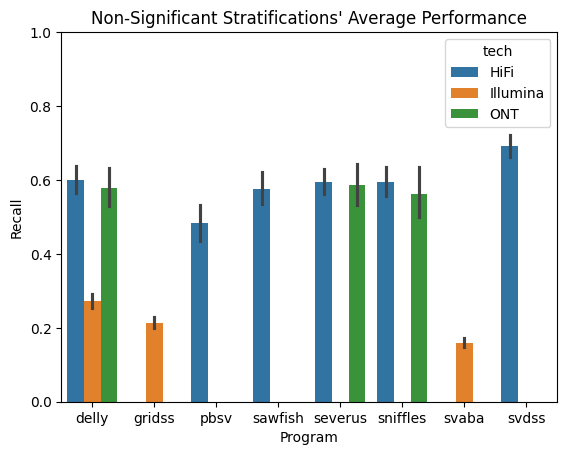

In [64]:
baseline = view[~view.index.isin(problems.index)].reset_index()
p = sb.barplot(data=baseline, x='prog', y='acc', hue='tech', 
           order=order, hue_order=hue_order)
_ = p.set(title="Non-Significant Stratifications' Average Performance", 
          xlabel="Program", 
          ylabel="Recall",
          ylim=(0,1))

In [65]:
view = data.set_index(['feature', 'value'])
view.sort_index(inplace=True)
subset = view[view.index.isin(problems.index)].reset_index()

In [66]:
renamer = {('VAF_bin', 'SomaticLow(<5%)'): "SomaticLow(<5%)",
           ('isolated', 'False'): "Neighboring",
           ('TRF', 'True'): "TR Regions",
           ('svtype', "INS"): "Insertions",
           ('VAF_bin', 'Somatic'): "Somatic",
           ('szbin', '[50,100)'): "Small [50,100)",
           ('szbin', '[100,200)'): "Small [100,200)"}

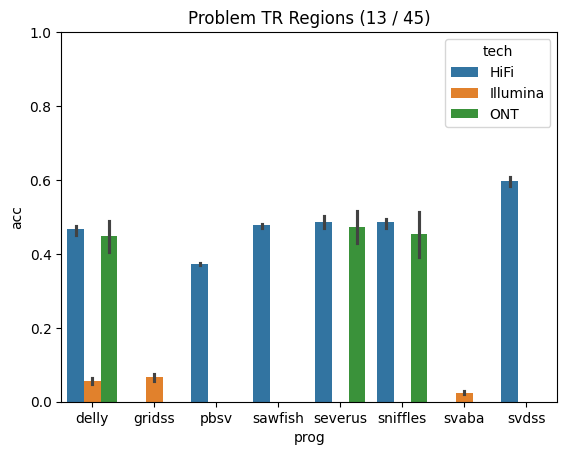

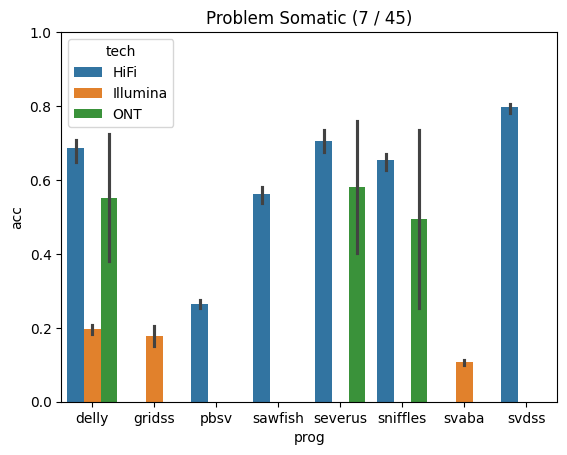

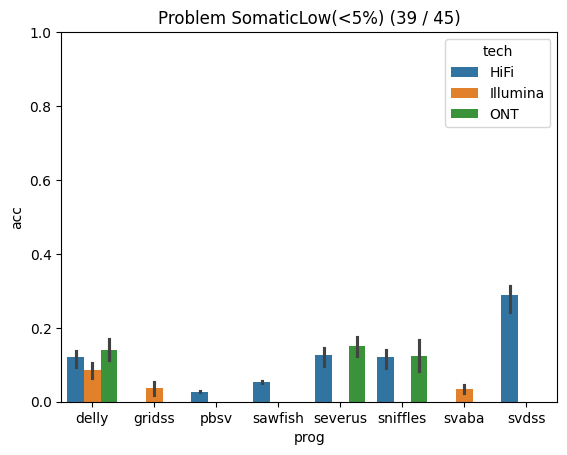

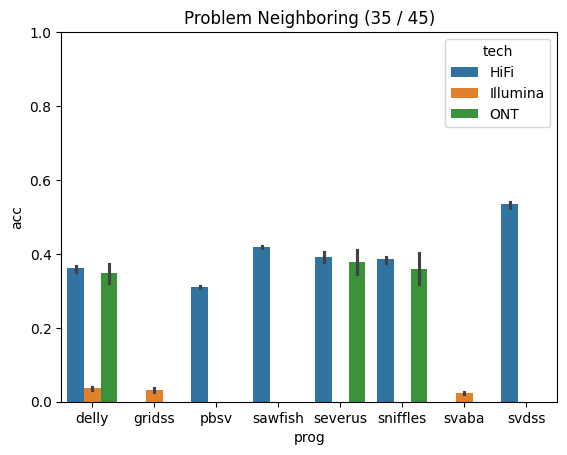

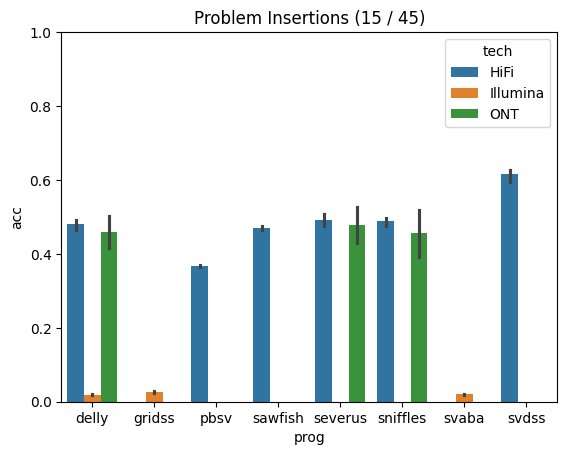

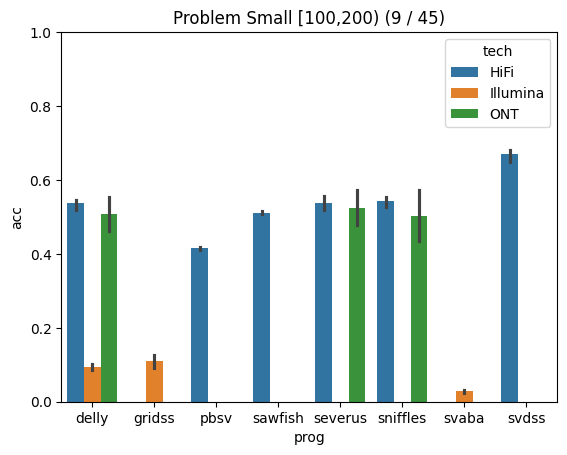

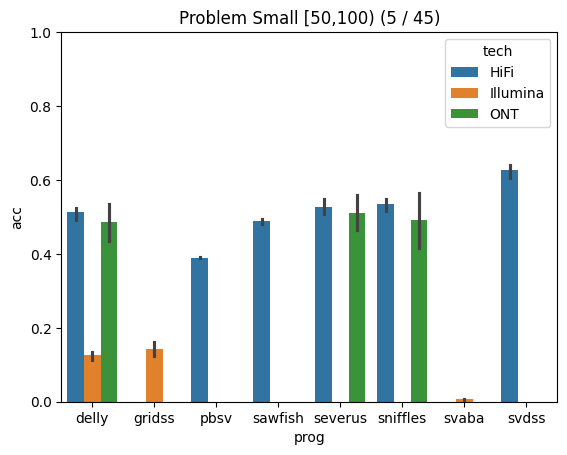

In [70]:
for i, df in subset.groupby(['feature', 'value']):
    p = sb.barplot(data=df, x='prog', y='acc', hue='tech', 
                   order=order,
                   hue_order=hue_order)
    p.set(title=f'Problem {renamer[i]} ({problems.loc[i]} / 45)', ylim=(0,1))
    plt.show()

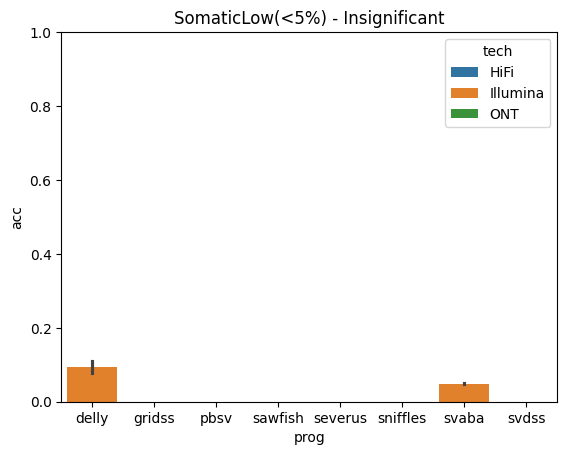

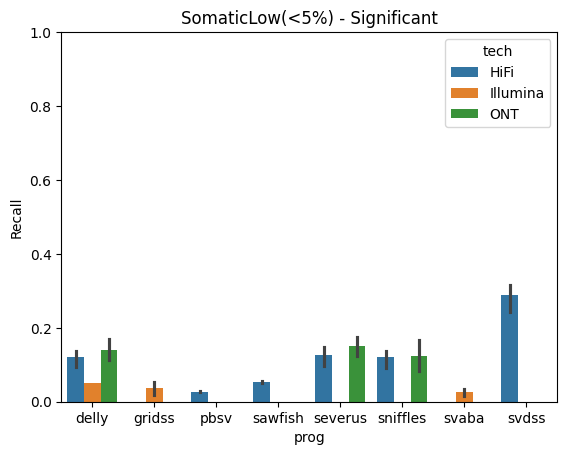

('VAF_bin', 'SomaticLow(<5%)') 39 / 45
	G= {'Illumina': 6} 
	P= {'HiFi': 24, 'Illumina': 9, 'ONT': 6}
	G= {'WashU': 2, 'BCM': 2, 'UW': 1, 'NYGC': 1} 
	P= {'UW': 11, 'BCM': 10, 'Broad': 9, 'WashU': 7, 'NYGC': 2}
	G= {'delly': 4, 'svaba': 2} 
	P= {'delly': 7, 'sniffles': 6, 'severus': 6, 'gridss': 5, 'svdss': 4, 'sawfish': 4, 'pbsv': 4, 'svaba': 3}



In [68]:
view = data.set_index(['feature', 'value'])
view.sort_index(inplace=True)
for i in problems.index:
    sub = view.loc[i]
    notproblem = sub[~sub['reject']]
    isproblem = sub[sub['reject']]
    p = sb.barplot(data=notproblem, x='prog', y='acc', hue='tech', 
               order=order, hue_order=hue_order,)
    p.set(title="SomaticLow(<5%) - Insignificant",
          ylim=(0,1))
    plt.show()

    p = sb.barplot(data=isproblem, x='prog', y='acc', hue='tech', 
               order=order, hue_order=hue_order)
    p.set(title="SomaticLow(<5%) - Significant", ylabel="Recall",
          ylim=(0,1))
    plt.show()
    
    print(i, problems.loc[i], '/', len(ptc))
    print('\tG=', notproblem['tech'].value_counts().to_dict(), '\n\tP=', isproblem['tech'].value_counts().to_dict())
    print('\tG=', notproblem['center'].value_counts().to_dict(), '\n\tP=', isproblem['center'].value_counts().to_dict())
    print('\tG=', notproblem['prog'].value_counts().to_dict(), '\n\tP=', isproblem['prog'].value_counts().to_dict())
    print()
    break

In [69]:
data[(data['center'] == 'merge') & (data['value'] == 'SomaticLow(<5%)')][
    ['prog', 'acc', 'reject']
]

,prog,acc,reject


In [115]:
ptc[ptc['tech'] == 'hifi']['center'].unique()

array(['BCM', 'UW', 'Broad', 'WashU', 'merge'], dtype=object)

In [116]:
100 + 100 + 60 + 60

320

In [21]:
data['tech'] = data['tech'].map({'ontstd': 'ONT', 'hifi': 'HiFi', 'ill':'Illumina'})

In [23]:
data[['prog', 'tech', 'center', 'feature', 'value', 'acc', 'delta', 'q1', 'q50', 'q99', 'obs', 'pval',
       'adj_pval', 'reject']].to_csv("surbscore.tsv", sep='\t', index=False)

In [24]:
!cat surbscore.tsv | pbcopy 


In [71]:
data[data['reject'] & (data['value'] == 'Somatic')]

,feature,value,acc,delta,q1,q50,q99,obs,pval,adj_pval,reject,prog,tech,center
1,VAF_bin,Somatic,0.2528,-50.2868,-24.0540,-0.2344,24.9212,8200,0.0000,0.0000,True,sniffles,ONT,UW
2,VAF_bin,Somatic,0.4024,-34.2982,-24.5224,-0.1641,25.0381,8200,0.0004,0.0027,True,severus,ONT,UW
2,VAF_bin,Somatic,0.3806,-36.0096,-24.5456,-0.1875,24.9920,8200,0.0001,0.0007,True,delly,ONT,UW
1,VAF_bin,Somatic,0.2590,-43.9804,-24.1006,-0.1875,25.0614,8200,0.0000,0.0000,True,pbsv,HiFi,Broad
1,VAF_bin,Somatic,0.2477,-44.6838,-24.1475,-0.1641,24.9212,8200,0.0000,0.0000,True,pbsv,HiFi,BCM
1,VAF_bin,Somatic,0.2754,-42.1518,-24.1939,-0.2110,24.9444,8200,0.0000,0.0000,True,pbsv,HiFi,UW
1,VAF_bin,Somatic,0.2729,-42.1284,-24.2408,-0.2344,24.9680,8200,0.0000,0.0000,True,pbsv,HiFi,WashU


In [74]:
ptc[ptc['tech'] == 'HiFi']['center'].unique()

array(['Broad', 'BCM', 'UW', 'WashU'], dtype=object)

ValueError: Unrecognized marker style 'center'

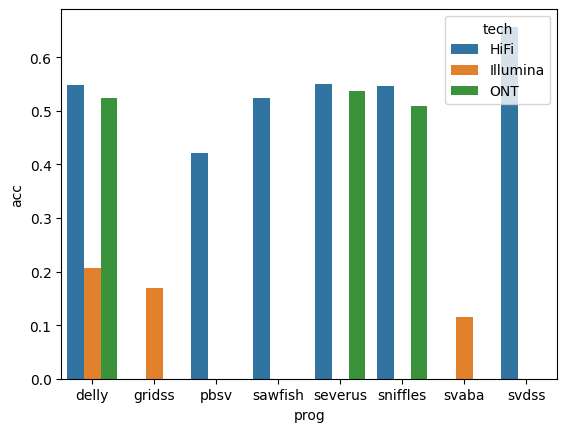

In [81]:
# Existing barplot
view = data.groupby(['prog', 'tech', 'center'])['acc'].mean().reset_index()
p = sb.barplot(data=view, x='prog', y='acc', hue='tech', order=order, hue_order=hue_order, errorbar=None)


# Overlay actual data points (per-center values)
sb.stripplot(data=view, x='prog', y='acc', hue='tech', 
             dodge=True, jitter=True, linewidth=0.5,
             order=order, hue_order=hue_order,
             marker='center', alpha=0.6, palette='dark:.3', ax=p)

# Remove duplicate legend (since barplot and stripplot both create one)
handles, labels = p.get_legend_handles_labels()
p.legend(handles[:len(hue_order)], labels[:len(hue_order)])

_ = p.set(title="All Stratifications Average Performance", 
          xlabel="Program", 
          ylabel="Recall",
          ylim=(0,1))


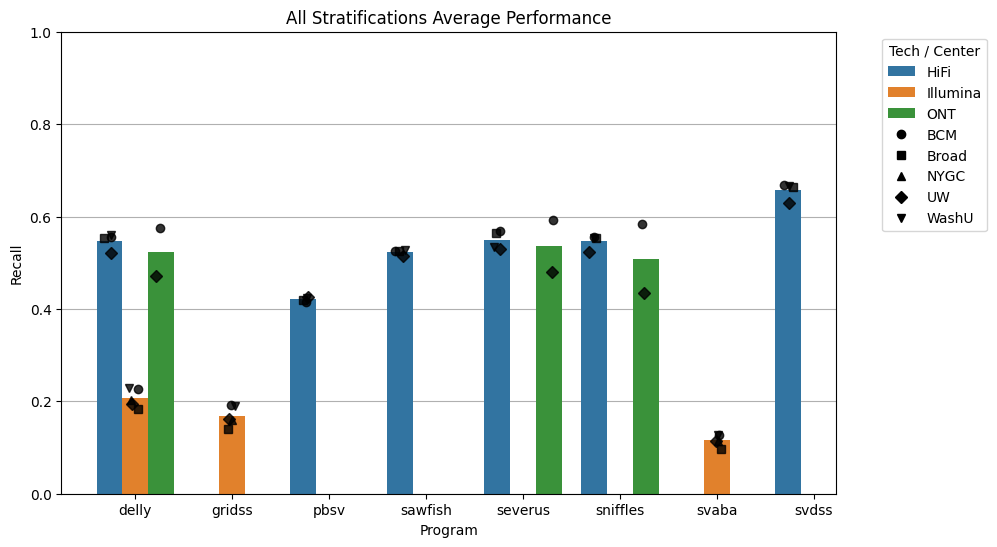

In [100]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assume: data has columns ['prog', 'tech', 'acc', 'center']
fig, ax = plt.subplots(figsize=(10, 6))

view = data.groupby(['prog', 'tech', 'center'])['acc'].mean().reset_index()

# 1. Draw the barplot with error bars
sb.barplot(data=view, x='prog', y='acc', hue='tech',
           order=order, hue_order=hue_order, ax=ax,
          errorbar=None, zorder=2)

# 2. Create a mapping of centers → marker
unique_centers = sorted(list(view['center'].unique()))
markers = ['o', 's', '^', 'D', 'v', 'X', 'P', '*', 'H']
marker_map = dict(zip(unique_centers, markers))

# 3. Compute width and dodge spacing
n_tech = len(hue_order)
bar_width = 0.8 / n_tech  # default Seaborn bar width
half = (n_tech - 1) / 2

# 4. Manually add points per row
import random
for i, row in view.iterrows():
    prog_index = order.index(row['prog'])
    tech_index = hue_order.index(row['tech'])
    dodge_offset = (tech_index - half) * bar_width
    xpos = prog_index + dodge_offset
    jitter_amt = 0.03  # adjust as needed
    jit = np.random.uniform(-jitter_amt, jitter_amt)
    xpos += jit
    ax.plot(xpos + jit, row['acc'],
            marker=marker_map[row['center']],
            color='black',
            markersize=6,
            linestyle='None',
            alpha=0.8,
            label=row['center'] if i == 0 else None,
            zorder=2)  # Add label only once


from matplotlib.lines import Line2D

# 1. Get tech legend handles (from barplot)
tech_handles, tech_labels = ax.get_legend_handles_labels()

# 2. Make center marker legend manually
center_handles = [
    Line2D([0], [0],
           marker=marker_map[c],
           color='black',
           linestyle='None',
           markersize=6,
           label=str(c))
    for c in unique_centers
]

# 3. Combine them
combined_handles = tech_handles[:len(hue_order)] + center_handles
combined_labels = tech_labels[:len(hue_order)] + [str(c) for c in unique_centers]

# 4. Add combined legend
ax.legend(combined_handles, combined_labels, title='Tech / Center',
          bbox_to_anchor=(1.05, 1), loc='upper left')


# 5. Clean up labels and limits
ax.set(title="All Stratifications Average Performance",
       xlabel="Program", ylabel="Recall", ylim=(0, 1))
plt.grid(axis='y', zorder=1)

In [101]:
problems

feature   value          
VAF_bin   SomaticLow(<5%)    39
isolated  False              35
svtype    INS                15
TRF       True               13
szbin     [100,200)           9
VAF_bin   Somatic             7
szbin     [50,100)            5
Name: count, dtype: int64

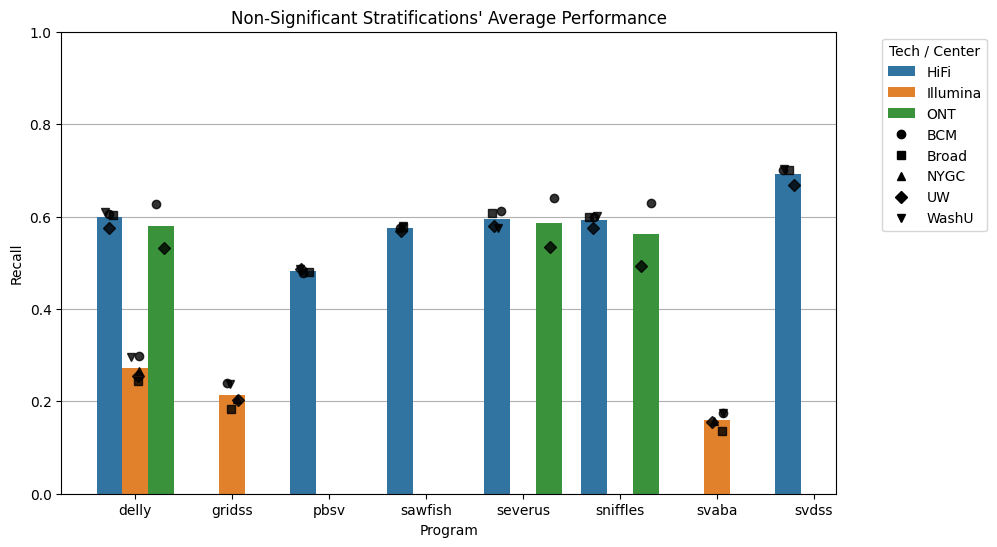

In [103]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assume: data has columns ['prog', 'tech', 'acc', 'center']
fig, ax = plt.subplots(figsize=(10, 6))

subset = data.set_index(['feature', 'value'])
subset = subset[~subset.index.isin(problems.index)]
view = subset.groupby(['prog', 'tech', 'center'])['acc'].mean().reset_index()

# 1. Draw the barplot with error bars
sb.barplot(data=view, x='prog', y='acc', hue='tech',
           order=order, hue_order=hue_order, ax=ax,
          errorbar=None, zorder=2)

# 2. Create a mapping of centers → marker
unique_centers = sorted(list(view['center'].unique()))
markers = ['o', 's', '^', 'D', 'v', 'X', 'P', '*', 'H']
marker_map = dict(zip(unique_centers, markers))

# 3. Compute width and dodge spacing
n_tech = len(hue_order)
bar_width = 0.8 / n_tech  # default Seaborn bar width
half = (n_tech - 1) / 2

# 4. Manually add points per row
import random
for i, row in view.iterrows():
    prog_index = order.index(row['prog'])
    tech_index = hue_order.index(row['tech'])
    dodge_offset = (tech_index - half) * bar_width
    xpos = prog_index + dodge_offset
    jitter_amt = 0.03  # adjust as needed
    jit = np.random.uniform(-jitter_amt, jitter_amt)
    xpos += jit
    ax.plot(xpos + jit, row['acc'],
            marker=marker_map[row['center']],
            color='black',
            markersize=6,
            linestyle='None',
            alpha=0.8,
            label=row['center'] if i == 0 else None,
            zorder=2)  # Add label only once


from matplotlib.lines import Line2D

# 1. Get tech legend handles (from barplot)
tech_handles, tech_labels = ax.get_legend_handles_labels()

# 2. Make center marker legend manually
center_handles = [
    Line2D([0], [0],
           marker=marker_map[c],
           color='black',
           linestyle='None',
           markersize=6,
           label=str(c))
    for c in unique_centers
]

# 3. Combine them
combined_handles = tech_handles[:len(hue_order)] + center_handles
combined_labels = tech_labels[:len(hue_order)] + [str(c) for c in unique_centers]

# 4. Add combined legend
ax.legend(combined_handles, combined_labels, title='Tech / Center',
          bbox_to_anchor=(1.05, 1), loc='upper left')


# 5. Clean up labels and limits
ax.set(title="Non-Significant Stratifications' Average Performance",
       xlabel="Program", ylabel="Recall", ylim=(0, 1))
plt.grid(axis='y', zorder=1)

In [105]:
problems

feature   value          
VAF_bin   SomaticLow(<5%)    39
isolated  False              35
svtype    INS                15
TRF       True               13
szbin     [100,200)           9
VAF_bin   Somatic             7
szbin     [50,100)            5
Name: count, dtype: int64

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1653/3193206326.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = subset.loc[('VAF_bin', 'SomaticLow(<5%)')]


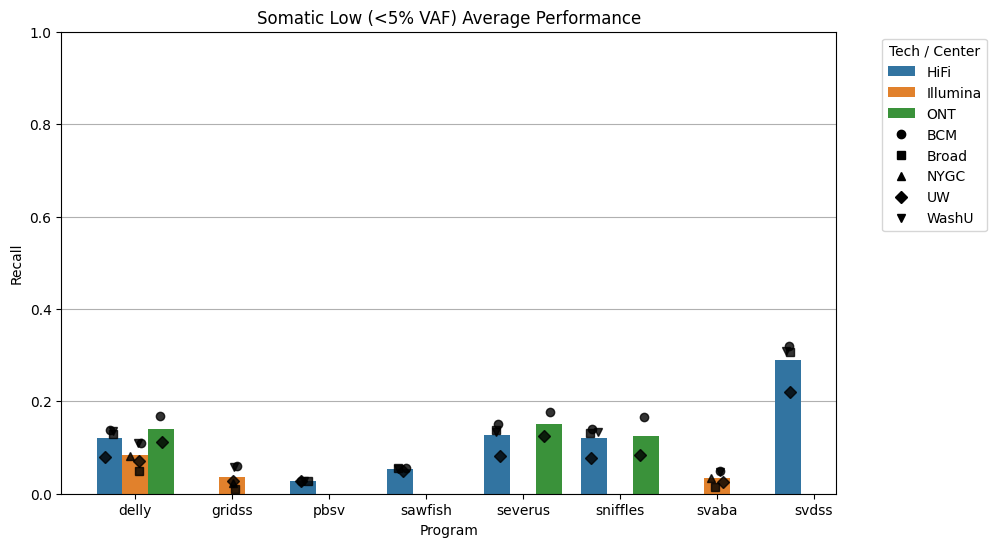

In [107]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assume: data has columns ['prog', 'tech', 'acc', 'center']
fig, ax = plt.subplots(figsize=(10, 6))

subset = data.set_index(['feature', 'value'])
subset = subset.loc[('VAF_bin', 'SomaticLow(<5%)')]
view = subset.groupby(['prog', 'tech', 'center'])['acc'].mean().reset_index()

# 1. Draw the barplot with error bars
sb.barplot(data=view, x='prog', y='acc', hue='tech',
           order=order, hue_order=hue_order, ax=ax,
          errorbar=None, zorder=2)

# 2. Create a mapping of centers → marker
unique_centers = sorted(list(view['center'].unique()))
markers = ['o', 's', '^', 'D', 'v', 'X', 'P', '*', 'H']
marker_map = dict(zip(unique_centers, markers))

# 3. Compute width and dodge spacing
n_tech = len(hue_order)
bar_width = 0.8 / n_tech  # default Seaborn bar width
half = (n_tech - 1) / 2

# 4. Manually add points per row
import random
for i, row in view.iterrows():
    prog_index = order.index(row['prog'])
    tech_index = hue_order.index(row['tech'])
    dodge_offset = (tech_index - half) * bar_width
    xpos = prog_index + dodge_offset
    jitter_amt = 0.03  # adjust as needed
    jit = np.random.uniform(-jitter_amt, jitter_amt)
    xpos += jit
    ax.plot(xpos + jit, row['acc'],
            marker=marker_map[row['center']],
            color='black',
            markersize=6,
            linestyle='None',
            alpha=0.8,
            label=row['center'] if i == 0 else None,
            zorder=2)  # Add label only once


from matplotlib.lines import Line2D

# 1. Get tech legend handles (from barplot)
tech_handles, tech_labels = ax.get_legend_handles_labels()

# 2. Make center marker legend manually
center_handles = [
    Line2D([0], [0],
           marker=marker_map[c],
           color='black',
           linestyle='None',
           markersize=6,
           label=str(c))
    for c in unique_centers
]

# 3. Combine them
combined_handles = tech_handles[:len(hue_order)] + center_handles
combined_labels = tech_labels[:len(hue_order)] + [str(c) for c in unique_centers]

# 4. Add combined legend
ax.legend(combined_handles, combined_labels, title='Tech / Center',
          bbox_to_anchor=(1.05, 1), loc='upper left')


# 5. Clean up labels and limits
ax.set(title="Somatic Low (<5% VAF) Average Performance",
       xlabel="Program", ylabel="Recall", ylim=(0, 1))
plt.grid(axis='y', zorder=1)


/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1653/1286290877.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = subset.loc[('isolated', 'False')]


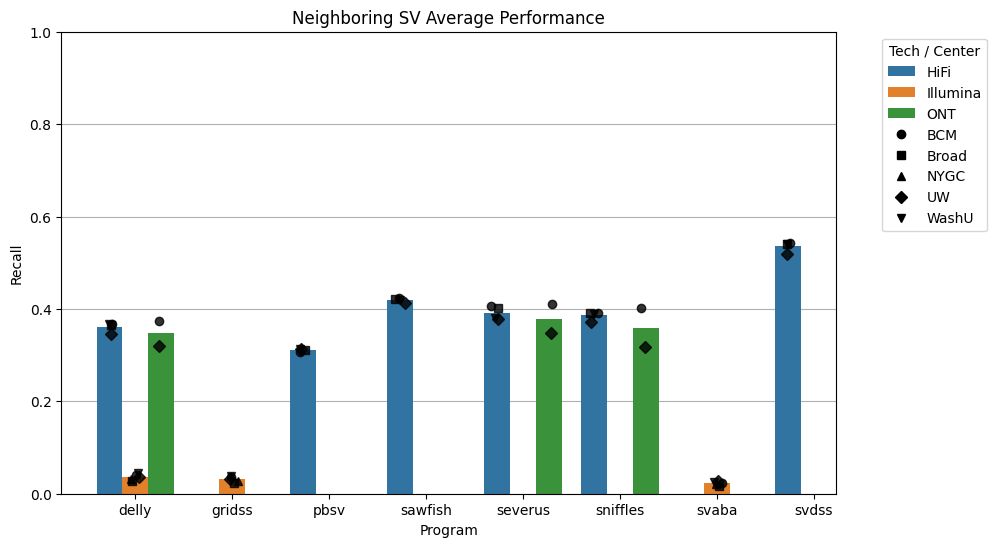

In [108]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assume: data has columns ['prog', 'tech', 'acc', 'center']
fig, ax = plt.subplots(figsize=(10, 6))

subset = data.set_index(['feature', 'value'])
subset = subset.loc[('isolated', 'False')]
view = subset.groupby(['prog', 'tech', 'center'])['acc'].mean().reset_index()

# 1. Draw the barplot with error bars
sb.barplot(data=view, x='prog', y='acc', hue='tech',
           order=order, hue_order=hue_order, ax=ax,
          errorbar=None, zorder=2)

# 2. Create a mapping of centers → marker
unique_centers = sorted(list(view['center'].unique()))
markers = ['o', 's', '^', 'D', 'v', 'X', 'P', '*', 'H']
marker_map = dict(zip(unique_centers, markers))

# 3. Compute width and dodge spacing
n_tech = len(hue_order)
bar_width = 0.8 / n_tech  # default Seaborn bar width
half = (n_tech - 1) / 2

# 4. Manually add points per row
import random
for i, row in view.iterrows():
    prog_index = order.index(row['prog'])
    tech_index = hue_order.index(row['tech'])
    dodge_offset = (tech_index - half) * bar_width
    xpos = prog_index + dodge_offset
    jitter_amt = 0.03  # adjust as needed
    jit = np.random.uniform(-jitter_amt, jitter_amt)
    xpos += jit
    ax.plot(xpos + jit, row['acc'],
            marker=marker_map[row['center']],
            color='black',
            markersize=6,
            linestyle='None',
            alpha=0.8,
            label=row['center'] if i == 0 else None,
            zorder=2)  # Add label only once


from matplotlib.lines import Line2D

# 1. Get tech legend handles (from barplot)
tech_handles, tech_labels = ax.get_legend_handles_labels()

# 2. Make center marker legend manually
center_handles = [
    Line2D([0], [0],
           marker=marker_map[c],
           color='black',
           linestyle='None',
           markersize=6,
           label=str(c))
    for c in unique_centers
]

# 3. Combine them
combined_handles = tech_handles[:len(hue_order)] + center_handles
combined_labels = tech_labels[:len(hue_order)] + [str(c) for c in unique_centers]

# 4. Add combined legend
ax.legend(combined_handles, combined_labels, title='Tech / Center',
          bbox_to_anchor=(1.05, 1), loc='upper left')


# 5. Clean up labels and limits
ax.set(title="Neighboring SV Average Performance",
       xlabel="Program", ylabel="Recall", ylim=(0, 1))
plt.grid(axis='y', zorder=1)


In [111]:
data['acc'].mean(), data.size

(0.4127544444444444, 12600)

In [113]:
lr = data['tech'].isin(['HiFi', 'ONT'])
data[lr]['acc'].mean(), data[~lr]['acc'].mean()

(0.5371910000000001, 0.16388133333333332)

In [114]:
s = data.set_index(['feature', 'value'])
s[~s.index.isin(problems.index)]['acc'].mean()

0.46284888888888887

In [116]:
s[s.index.isin(problems.index)]['acc'].mean()

0.31972190476190476

In [117]:
problems

feature   value          
VAF_bin   SomaticLow(<5%)    39
isolated  False              35
svtype    INS                15
TRF       True               13
szbin     [100,200)           9
VAF_bin   Somatic             7
szbin     [50,100)            5
Name: count, dtype: int64

In [119]:
s = data[data['value'] == 'SomaticLow(<5%)']
s[~s['reject']].sort_values(by='acc', ascending=False)

,feature,value,acc,delta,q1,q50,q99,obs,pval,adj_pval,reject,prog,tech,center
4,VAF_bin,SomaticLow(<5%),0.1098,-20.2305,-23.2998,0.0209,22.6108,13184,0.0233,0.0932,False,delly,Illumina,BCM
4,VAF_bin,SomaticLow(<5%),0.1095,-20.8360,-23.3415,0.0000,22.4855,13184,0.0206,0.0824,False,delly,Illumina,WashU
4,VAF_bin,SomaticLow(<5%),0.0825,-23.2578,-23.1536,-0.0209,22.4020,13184,0.0097,0.0388,False,delly,Illumina,NYGC
4,VAF_bin,SomaticLow(<5%),0.0709,-25.7423,-23.0910,0.0000,22.3814,13184,0.0040,0.0160,False,delly,Illumina,UW
5,VAF_bin,SomaticLow(<5%),0.0501,-22.6941,-23.1745,-0.0731,22.4649,13184,0.0126,0.0420,False,svaba,Illumina,BCM
5,VAF_bin,SomaticLow(<5%),0.0478,-25.0115,-23.1743,-0.0418,22.4444,13184,0.0059,0.0197,False,svaba,Illumina,WashU


In [122]:
s[~s['reject']].sort_values(by='acc', ascending=False).groupby('prog')['acc'].mean()

prog
delly    0.093175
svaba    0.048950
Name: acc, dtype: float64

In [121]:
ptc[ptc['tech'] == 'Illumina']['prog'].unique()

array(['svaba', 'delly', 'gridss'], dtype=object)

In [126]:
data[data['prog'] == 'svdss']['acc'].mean()

0.65699875

In [128]:
data[(data['prog'] == 'delly') & (data['tech'] == 'Illumina') & (data['center'].isin(['BCM', 'WashU', 'NYGC', 'UW']))]['acc'].mean()

0.21318125000000002

In [135]:
data[(data['tech'] == 'ONT') &
     (data['value'] == 'Somatic')].sort_values(by='center')

,feature,value,acc,delta,q1,q50,q99,obs,pval,adj_pval,reject,prog,tech,center
14,VAF_bin,Somatic,0.7348,16.7623,-24.7566,-0.2344,24.4992,8200,0.9466,1.0000,False,sniffles,ONT,BCM
15,VAF_bin,Somatic,0.7590,24.4284,-24.7568,-0.2110,24.4288,8200,0.9900,1.0000,False,severus,ONT,BCM
14,VAF_bin,Somatic,0.7243,21.8261,-24.6630,-0.2344,24.3820,8200,0.9813,1.0000,False,delly,ONT,BCM
1,VAF_bin,Somatic,0.2528,-50.2868,-24.0540,-0.2344,24.9212,8200,0.0000,0.0000,True,sniffles,ONT,UW
2,VAF_bin,Somatic,0.4024,-34.2982,-24.5224,-0.1641,25.0381,8200,0.0004,0.0027,True,severus,ONT,UW
2,VAF_bin,Somatic,0.3806,-36.0096,-24.5456,-0.1875,24.9920,8200,0.0001,0.0007,True,delly,ONT,UW


In [136]:
data[(data['tech'] == 'ONT') &
     (data['value'] == 'Somatic')].groupby('center')['acc'].mean()

center
BCM    0.739367
UW     0.345267
Name: acc, dtype: float64

In [139]:
data[(data['prog'] == 'pbsv') &
     (data['feature'] == 'VAF_bin')].groupby('value')['acc'].mean()

value
GermlineHet        0.846600
GermlineHom        0.931850
Somatic            0.263750
SomaticLow(<5%)    0.027125
Name: acc, dtype: float64

In [129]:
data[(data['prog'].isin(['sniffles', 'severus', 'delly'])
      & (data['tech'].isin(['ONT'])
      

,feature,value,acc,delta,q1,q50,q99,obs,pval,adj_pval,reject,prog,tech,center
0,VAF_bin,SomaticLow(<5%),0.1657,-111.2367,-23.2374,-0.0835,22.4020,13184,0.0000,0.0000,True,sniffles,ONT,BCM
1,isolated,False,0.4017,-56.4174,-21.5156,0.1393,20.7502,12401,0.0000,0.0000,True,sniffles,ONT,BCM
2,svtype,INS,0.5180,-21.6457,-21.3051,0.0448,21.5383,20545,0.0090,0.0600,False,sniffles,ONT,BCM
3,TRF,True,0.5145,-16.1505,-20.4953,-0.2896,20.6483,19712,0.0385,0.1925,False,sniffles,ONT,BCM
4,szbin,>=5k,0.4973,-24.0054,-38.0837,0.1805,38.4447,931,0.0757,0.3028,False,sniffles,ONT,BCM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,szbin,"[100,200)",0.4169,11.0931,-31.7061,-0.0393,31.3127,6256,0.7955,0.9812,False,pbsv,HiFi,WashU
16,svtype,DEL,0.4600,8.8412,-20.8566,0.0179,21.1796,13595,0.8340,0.9812,False,pbsv,HiFi,WashU
17,isolated,True,0.4587,23.0996,-20.6280,0.1044,20.9065,21739,0.9945,1.0000,False,pbsv,HiFi,WashU
18,VAF_bin,GermlineHet,0.8469,75.6553,-24.1927,-0.3168,23.2422,7448,1.0000,1.0000,False,pbsv,HiFi,WashU


In [131]:
ptc[ptc['prog'].isin(['sniffles', 'severus', 'delly'])
   & (ptc['tech'] == 'ONT')]

,prog,tech,center
0,sniffles,ONT,BCM
2,sniffles,ONT,UW
6,severus,ONT,BCM
8,severus,ONT,UW
21,delly,ONT,BCM
25,delly,ONT,UW


In [144]:
x = ptc.groupby(['center', 'tech']).size().unstack()
x.loc['Total'] = (~x.isna()).sum()
x

tech,HiFi,Illumina,ONT
center,,,
BCM,6.0,3.0,3.0
Broad,6.0,3.0,NaN
NYGC,NaN,3.0,NaN
UW,6.0,3.0,3.0
WashU,6.0,3.0,NaN
Total,4.0,5.0,2.0


In [167]:
data[~data['reject'] & (data['feature'] == 'VAF_bin') & (data['value'] == 'SomaticLow(<5%)')]

,feature,value,acc,delta,q1,q50,q99,obs,pval,adj_pval,reject,prog,tech,center
5,VAF_bin,SomaticLow(<5%),0.0478,-25.0115,-23.1743,-0.0418,22.4444,13184,0.0059,0.0197,False,svaba,Illumina,WashU
5,VAF_bin,SomaticLow(<5%),0.0501,-22.6941,-23.1745,-0.0731,22.4649,13184,0.0126,0.0420,False,svaba,Illumina,BCM
4,VAF_bin,SomaticLow(<5%),0.0709,-25.7423,-23.0910,0.0000,22.3814,13184,0.0040,0.0160,False,delly,Illumina,UW
4,VAF_bin,SomaticLow(<5%),0.1095,-20.8360,-23.3415,0.0000,22.4855,13184,0.0206,0.0824,False,delly,Illumina,WashU
4,VAF_bin,SomaticLow(<5%),0.0825,-23.2578,-23.1536,-0.0209,22.4020,13184,0.0097,0.0388,False,delly,Illumina,NYGC
4,VAF_bin,SomaticLow(<5%),0.1098,-20.2305,-23.2998,0.0209,22.6108,13184,0.0233,0.0932,False,delly,Illumina,BCM


In [145]:
data[~data['reject'] & (data['feature'] == 'isolated') & (data['value'] == 'False')]

,feature,value,acc,delta,q1,q50,q99,obs,pval,adj_pval,reject,prog,tech,center
2,isolated,False,0.3174,-25.1711,-21.0114,0.0348,20.8024,12401,0.0036,0.0240,False,sniffles,ONT,UW
3,isolated,False,0.0277,-25.3800,-20.9937,0.0522,20.5235,12401,0.0031,0.0155,False,svaba,Illumina,UW
5,isolated,False,0.0173,-19.6356,-21.0635,0.0348,20.8200,12401,0.0157,0.0523,False,svaba,Illumina,Broad
1,isolated,False,0.4221,-27.8867,-21.3242,0.0522,20.7672,12401,0.0012,0.0120,False,sawfish,HiFi,Broad
1,isolated,False,0.4228,-27.2948,-21.2203,0.0696,20.7670,12401,0.0014,0.0140,False,sawfish,HiFi,BCM
1,isolated,False,0.4134,-25.7804,-21.3072,0.0870,20.8194,12401,0.0027,0.0270,False,sawfish,HiFi,UW
2,isolated,False,0.3119,-20.9237,-21.1154,0.0696,20.7326,12401,0.0109,0.0727,False,pbsv,HiFi,Broad
2,isolated,False,0.3077,-21.4111,-21.0807,0.0522,20.6979,12401,0.0092,0.0613,False,pbsv,HiFi,BCM
2,isolated,False,0.3138,-23.4478,-21.2022,0.0696,20.9416,12401,0.0051,0.0340,False,pbsv,HiFi,UW
2,isolated,False,0.3126,-23.0996,-21.0633,0.0522,20.9761,12401,0.0058,0.0387,False,pbsv,HiFi,WashU


In [146]:
data[(data['feature'] == 'isolated') & (data['value'] == 'False') & (data['prog'] == 'sawfish')]

,feature,value,acc,delta,q1,q50,q99,obs,pval,adj_pval,reject,prog,tech,center
1,isolated,False,0.4221,-27.8867,-21.3242,0.0522,20.7672,12401,0.0012,0.012,False,sawfish,HiFi,Broad
1,isolated,False,0.4228,-27.2948,-21.2203,0.0696,20.7670,12401,0.0014,0.014,False,sawfish,HiFi,BCM
1,isolated,False,0.4134,-25.7804,-21.3072,0.0870,20.8194,12401,0.0027,0.027,False,sawfish,HiFi,UW
1,isolated,False,0.4200,-29.7144,-21.2722,0.1044,20.7674,12401,0.0006,0.006,True,sawfish,HiFi,WashU


In [165]:
data[(data['feature'] == 'isolated') & (data['value'] == 'False') & (data['prog'] == 'pbsv')]

,feature,value,acc,delta,q1,q50,q99,obs,pval,adj_pval,reject,prog,tech,center
2,isolated,False,0.3119,-20.9237,-21.1154,0.0696,20.7326,12401,0.0109,0.0727,False,pbsv,HiFi,Broad
2,isolated,False,0.3077,-21.4111,-21.0807,0.0522,20.6979,12401,0.0092,0.0613,False,pbsv,HiFi,BCM
2,isolated,False,0.3138,-23.4478,-21.2022,0.0696,20.9416,12401,0.0051,0.0340,False,pbsv,HiFi,UW
2,isolated,False,0.3126,-23.0996,-21.0633,0.0522,20.9761,12401,0.0058,0.0387,False,pbsv,HiFi,WashU


In [151]:
data[data['reject']].sort_values(by='adj_pval', ascending=False)['adj_pval'].value_counts().sort_index()

adj_pval
0.0000    98
0.0005     2
0.0007     1
0.0010     2
0.0027     1
0.0040     2
0.0045     1
0.0055     4
0.0060     3
0.0065     2
0.0075     1
0.0080     1
0.0083     2
0.0087     1
0.0096     2
Name: count, dtype: int64

In [164]:
a = data[(data['prog'] == 'sawfish') & (data['center'] == 'WashU')].groupby(['feature', 'value'])['acc'].mean()
b = data[(data['prog'] == 'sawfish') & (data['center'] != 'WashU')].groupby(['feature', 'value'])['acc'].mean()
c = data[(data['prog'] == 'sawfish') & (data['center'] != 'WashU')].groupby(['feature', 'value'])['acc'].std()
a.to_frame().join(b.to_frame(), lsuffix='wu').join(c.to_frame(), rsuffix='std')

accwu       acc    accstd
feature  value                                      
TRF      False            0.5446  0.535100  0.007015
         True             0.4803  0.475933  0.007670
VAF_bin  GermlineHet      0.9102  0.910667  0.001415
         GermlineHom      0.9527  0.951733  0.001704
         Somatic          0.5843  0.556000  0.026073
         SomaticLow(<5%)  0.0529  0.053700  0.003195
isolated False            0.4200  0.419433  0.005237
         True             0.5574  0.547433  0.008523
svtype   DEL              0.5579  0.547300  0.008426
         INS              0.4741  0.470267  0.006640
szbin    >=5k             0.4211  0.422833  0.012626
         [100,200)        0.5144  0.510767  0.006568
         [1k,2.5k)        0.5069  0.503900  0.003064
         [2.5k,5k)        0.4665  0.460433  0.010966
         [200,300)        0.5071  0.498300  0.002951
         [300,400)        0.5328  0.524200  0.010416
         [400,600)        0.5409  0.536333  0.004252
         [50,100)         0.4951  0.487933  0.009968
         [600,800)        0.5109  0.496700  0.006755
         [800,1k)         0.5357  0.524867  0.005616

In [163]:
c

feature   value          
TRF       False             NaN
          True              NaN
VAF_bin   GermlineHet       NaN
          GermlineHom       NaN
          Somatic           NaN
          SomaticLow(<5%)   NaN
isolated  False             NaN
          True              NaN
svtype    DEL               NaN
          INS               NaN
szbin     >=5k              NaN
          [100,200)         NaN
          [1k,2.5k)         NaN
          [2.5k,5k)         NaN
          [200,300)         NaN
          [300,400)         NaN
          [400,600)         NaN
          [50,100)          NaN
          [600,800)         NaN
          [800,1k)          NaN
Name: acc, dtype: float64